# Paquetes necesarios

In [1]:
import cv2  
import math 
from ultralytics import YOLO
import pytesseract
import easyocr

## 5.1 Tarea

En esta práctica describo en primer término la tarea:  **El objetivo es desarrollar un prototipo de sistema que identifique la matrícula de un vehículo, bien desde una imagen o desde un vídeo**. Como alternativa, será admisible un escenario donde se combine el uso de detectores de objetos, y reconocimiento de texto.

Nos centraremos en matrículas españolas, siendo una primera subtarea recopilar o capturar imágenes o vídeos que contengan vehículos con su matrícula visible. Si necesitan cámaras, trípode, etc. hablen conmigo.

Si bien cuentan con libertad a la hora de escoger los módulos que integren en el prototipo, les propongo los siguientes apartados:

- un detector de objetos, que permita localizar vehículos
- un localizador de matrículas
- y un reconocedor de texto

Para la detección, les propongo hacer uso de YOLOv8, para el reconocimiento de texto, les muestro dos OCRs diferentes. De cara a localizar las matrículas, les sugiero dos fases:

- En una primera fase, tras detectar un coche, las zonas probables de la matrícula estarán en su parte inferior, y además se asume que se corresponde a una zona rectangular (su contorno lo es)
- En una segunda fase, se plantea realizar un entrenamiento de YOLOv8 para detectar el objeto de interés: matrículas

# Sistema detector


In [10]:
from IPython.display import display, Image
import os
import cv2
import easyocr
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt

class DetectorDeMatriculas:
    def __init__(self, model_path, language='en'):
        self.model = YOLO(model_path)
        self.reader = easyocr.Reader([language])        
        self.__objNames = { "car": "coche", "motorbike": "motocicleta", "bus": "autobús" } # Diccionario de traducción privado

    def mostrar_y_guardar_resultados(self, img, img_name, matriculas_detectadas):
        output_dir = './outputs'
        os.makedirs(output_dir, exist_ok=True)
        result_image_path = os.path.join(output_dir, f'output_{img_name}')
        cv2.imwrite(result_image_path, img)
        display(Image(filename=result_image_path))

        for matricula in matriculas_detectadas:
            print(matricula)

    def aplicar_canny(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return cv2.Canny(gray, 50, 200)

    def aplicar_sobel(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        return np.hypot(sobelx, sobely).astype(np.uint8)

    def aplicar_umbralizacion(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    def localizar_matriculas(self, vehicle_roi):
        resultados = self.reader.readtext(vehicle_roi)
        return resultados
    
    def detectar_vehiculos(self, img):
        results = self.model(img, stream=False)
        boxes = []
        class_names = []
        for r in results:
            boxes.extend(r.boxes)
            class_names.extend([self.model.names[int(box.cls[0])] for box in r.boxes])
        return boxes, class_names
    
    def _procesar_fotograma(self, img):
        boxes, class_names = self.detectar_vehiculos(img)
        matriculas_detectadas = []

        for box, class_name in zip(boxes, class_names):
            if class_name in ["car", "motorbike", "bus"]:
                x1, y1, x2, y2 = [int(coord) for coord in box.xyxy[0]]
                
                 # Dibuja un rectángulo alrededor del vehículo
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
                cv2.putText(img, self.__objNames[class_name], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)


                vehicle_roi = img[y1:y2, x1:x2]

                resultados_ocr = self.localizar_matriculas(vehicle_roi)
                for result_ocr in resultados_ocr:
                    text = result_ocr[1]
                    top_left = tuple([int(coord) for coord in result_ocr[0][0]])
                    bottom_right = tuple([int(coord) for coord in result_ocr[0][2]])
                    cv2.rectangle(vehicle_roi, top_left, bottom_right, (255, 0, 0), 3)
                    matriculas_detectadas.append(f"Matrícula del {self.__objNames[class_name]}: {text}")
                

        return img, matriculas_detectadas

    def procesar_imagen(self, img_path):
        img = cv2.imread(img_path)
        img, matriculas_detectadas = self._procesar_fotograma(img)
        self.mostrar_y_guardar_resultados(img, os.path.basename(img_path), matriculas_detectadas)


    def procesar_video(self, video_path):
        cap = cv2.VideoCapture(video_path)
    
        while True:
            ret, img = cap.read()
            if not ret:
                print("Fin del video.")
                break
            
            img, matriculas_detectadas = self._procesar_fotograma(img)
            cv2.imshow('Video', img)
            
            for matricula in matriculas_detectadas:
                print("Matricula: ", matricula)
    
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            
        cap.release()
        cv2.destroyAllWindows()


    def detectar(self, path, es_video=False):
        if es_video:
            self.procesar_video(path)
        else:
            self.procesar_imagen(path)

# Ejemplo de uso
detector = DetectorDeMatriculas('yolov8n.pt')
# for i in range(1,16):
    # detector.detectar(f'./images/{i}.png')
detector.detectar(f'./videos/video2.mp4', es_video=True)




0: 384x640 4 cars, 23.0ms
Speed: 3.0ms preprocess, 23.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 15.0ms
Speed: 3.0ms preprocess, 15.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 5.0ms
Speed: 2.0ms preprocess, 5.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 5.0ms
Speed: 2.0ms preprocess, 5.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at sha

KeyboardInterrupt: 

# Detector de matriculas desde imagen 


0: 640x640 1 car, 16.0ms
Speed: 3.9ms preprocess, 16.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)
Matrícula del car: Dei
Matrícula del car: t


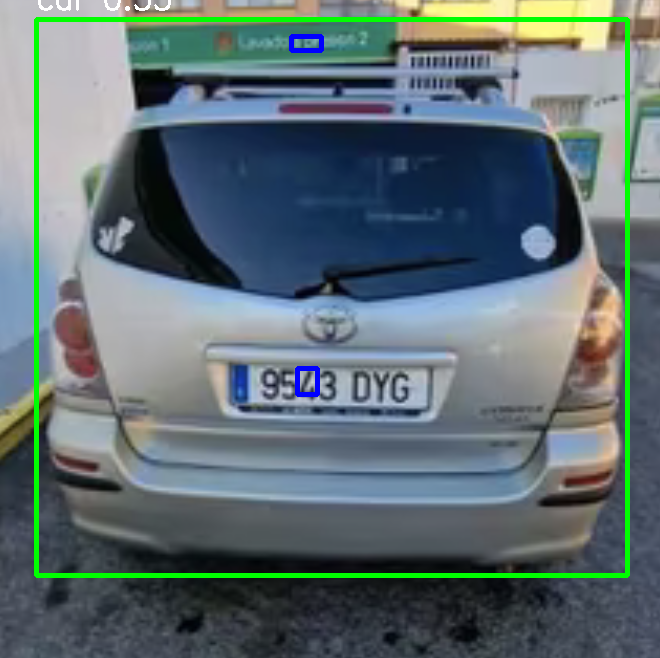


0: 448x640 2 cars, 1 truck, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


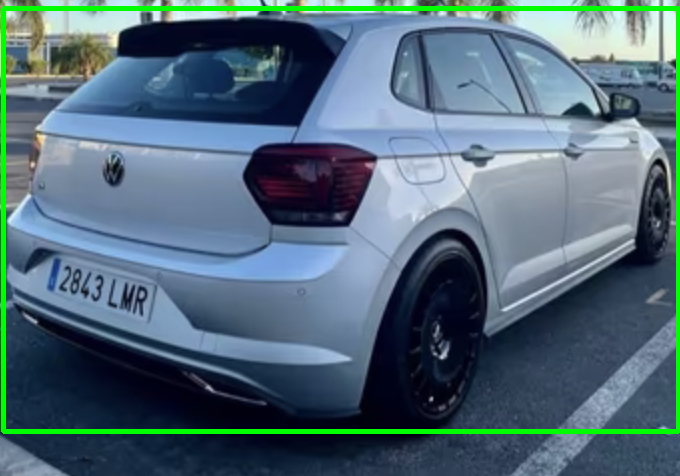


0: 448x640 1 car, 9.9ms
Speed: 1.0ms preprocess, 9.9ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


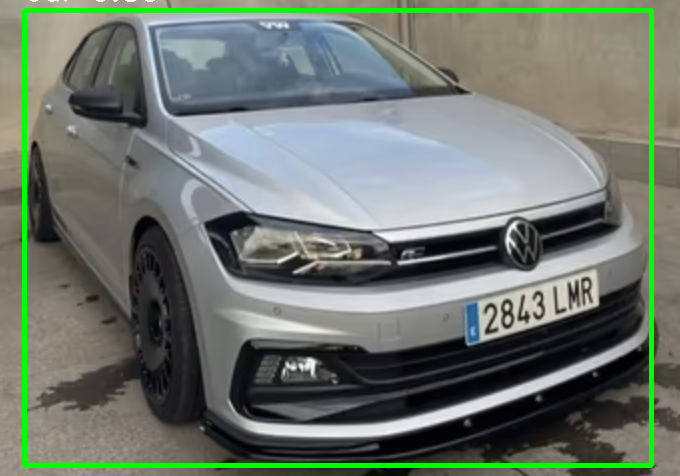

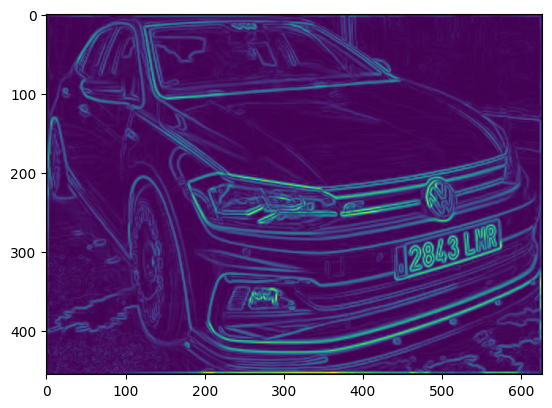

In [6]:
from IPython.display import display, Image
import os
import cv2
import easyocr
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt

def aplicar_canny(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    canny = cv2.Canny(gray, 50, 200)
    plt.imshow(canny)
    return canny

def aplicar_sobel(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel = np.hypot(sobelx, sobely)
    plt.imshow(sobel)
    return sobel.astype(np.uint8)

def aplicar_umbralizacion(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)    
    return threshold

def encontrar_contornos(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contornos, _ = cv2.findContours(threshold, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    plt.imshow(contornos)
    return contornos


def localizar_matriculas(vehicle_roi, reader):
    # Se pueden probar diferentes técnicas aquí y comparar los resultados
    procesado_canny = aplicar_canny(vehicle_roi)
    procesado_sobel = aplicar_sobel(vehicle_roi)
    procesado_umbral = aplicar_umbralizacion(vehicle_roi)

    # Usar la imagen con la técnica que mejor funcione
    sin_preprocesamiento = reader.readtext(vehicle_roi)
    resultados_canny = reader.readtext(procesado_canny)
    resultados_sobel = reader.readtext(procesado_sobel)
    resultados_umbral = reader.readtext(procesado_umbral)

    # Por ahora, usaremos los resultados sin preprocesamiento
    return sin_preprocesamiento

def detectar_matriculas(image_path, model_path, confidence_threshold=0.5):
    model = YOLO(model_path)
    reader = easyocr.Reader(['en'])

    img = cv2.imread(image_path)
    results = model(img, stream=False)

    for r in results:
        boxes = r.boxes
        for box in boxes:
            x1, y1, x2, y2 = [int(coord) for coord in box.xyxy[0]]
            cls = int(box.cls[0])
            confidence = float(box.conf[0])

            if model.names[cls] in ["car", "motorbike", "bus"] and confidence > confidence_threshold:
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
                cv2.putText(img, f"{model.names[cls]} {confidence:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

                vehicle_roi = img[y1:y2, x1:x2]
                results_ocr = localizar_matriculas(vehicle_roi, reader)
                for result_ocr in results_ocr:
                    text = result_ocr[1]
                    top_left = tuple(result_ocr[0][0])
                    bottom_right = tuple(result_ocr[0][2])
                    cv2.rectangle(vehicle_roi, top_left, bottom_right, (255, 0, 0), 3)
                    print(f"Matrícula del {model.names[cls]}: {text}")

    output_dir = './outputs'
    os.makedirs(output_dir, exist_ok=True)
    result_image_path = os.path.join(output_dir, f'output_{os.path.basename(image_path)}')
    cv2.imwrite(result_image_path, img)
    display(Image(filename=result_image_path))

for i in range(1, 4):
    detectar_matriculas(image_path=f'./images/coche{i}.png', model_path='yolov8n.pt')


## Detector de matriculas video

In [4]:
!nvidia-smi

Wed Nov 29 01:13:40 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.17                 Driver Version: 546.17       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   48C    P8               3W / 120W |   1045MiB /  8188MiB |      5%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [14]:
import cv2
import time
import easyocr
from ultralytics import YOLO

def detectar_matriculas_video(video_path, model_path, confidence_threshold=0.5):
    # Carga del modelo YOLO
    model = YOLO('yolov8n.pt')
    
    # Carga del modelo OCR para la detección de matrículas
    reader = easyocr.Reader(['en'])

    # Nombre de las distintas clases de YOLO
    classNames = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat",
                  "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
                  "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
                  "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
                  "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup",
                  "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli",
                  "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed",
                  "diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone",
                  "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
                  "teddy bear", "hair drier", "toothbrush"
                  ]

    # Ruta del video que deseas cargar
    # video_path = 'video.mp4'
    cap = cv2.VideoCapture(video_path)

    # Establece un retraso de 100 milisegundos (0.1 segundos) entre fotogramas
    delay = 100

    while True:
        # Captura el fotograma del video
        ret, img = cap.read()

        if not ret:
            print("Fin del video.")
            break

        # Realiza inferencia en el fotograma con YOLO
        results = model(img, stream=True)

        # Para cada detección
        for r in results:
            boxes = r.boxes

            for box in boxes:
                # Contenedor
                x1, y1, x2, y2 = box.xyxy[0]
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)  # convertir a valores enteros

                # Clase
                cls = int(box.cls[0])
                class_name = classNames[cls]

                # Solo continuamos si la clase es un vehículo
                if class_name in ["car", "motorbike", "bus"]:
                    # Recorta la región de interés (ROI) que contiene el vehículo
                    vehicle_roi = img[y1:y2, x1:x2]

                    # Detección de matrícula con OCR
                    results_ocr = reader.readtext(vehicle_roi)

                    # Si se encuentra texto (matrícula)
                    if results_ocr:
                        #letras = results_ocr[0][1]
                        #numeros = results_ocr[1][1]
                        print(f"Matrícula del {class_name}: {results_ocr}")

                # Dibuja el contenedor y clase
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
                cv2.putText(img, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        # Muestra el fotograma con las detecciones
        cv2.imshow('Video', img)

        # Introduce un retraso entre fotogramas
        time.sleep(delay / 1000.0)

        # Rompe el bucle si se presiona la tecla 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Libera los recursos
    cap.release()
    cv2.destroyAllWindows()

# Uso de la función
detectar_matriculas_video(video_path = './videos/video1.mp4' , model_path = 'yolov8n.pt', confidence_threshold=0.5)


0: 640x384 (no detections), 25.0ms
Speed: 6.0ms preprocess, 25.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 18.0ms
Speed: 7.0ms preprocess, 18.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 41.0ms
Speed: 5.0ms preprocess, 41.0ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 car, 45.0ms
Speed: 6.0ms preprocess, 45.0ms inference, 19.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 cars, 14.0ms
Speed: 4.0ms preprocess, 14.0ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 cars, 48.0ms
Speed: 6.0ms preprocess, 48.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 cars, 34.0ms
Speed: 4.0ms preprocess, 34.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 cars, 34.0ms
Speed: 5.0ms preprocess, 34.0ms inference, 5.0ms postprocess per image at shap

KeyboardInterrupt: 

# Codigos antiguos

In [ ]:
from IPython.display import display, Image
import os
import cv2
import easyocr
from ultralytics import YOLO

def detectar_matriculas(image_path, model_path, confidence_threshold=0.5):
    # Carga del modelo YOLO
    model = YOLO(model_path)

    # Carga del modelo OCR para la detección de matrículas
    reader = easyocr.Reader(['en'])

    # Cargar imagen
    img = cv2.imread(image_path)

    # Realiza inferencia en la imagen con YOLO
    results = model(img, stream=False)

    # Para cada detección
    for r in results:
        boxes = r.boxes

        for box in boxes:
            # Coordenadas del contenedor
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

            # Clase y confianza
            cls = int(box.cls[0])
            class_name = model.names[cls]
            confidence = float(box.conf[0])

            # Solo continuamos si la clase es un vehículo y la confianza es alta
            if class_name in ["car", "motorbike", "bus"] and confidence > confidence_threshold:
                # Rodear el vehículo
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
                cv2.putText(img, f"{class_name} {confidence:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

                # Recorta la región de interés (ROI) que contiene el vehículo
                vehicle_roi = img[y1:y2, x1:x2]

                # Detección de matrícula con OCR
                results_ocr = reader.readtext(vehicle_roi)

                # Si se encuentra texto (matrícula)
                for result_ocr in results_ocr:
                    text = result_ocr[1]
                    top_left = tuple(result_ocr[0][0])
                    bottom_right = tuple(result_ocr[0][2])
                    text_top_left = (int(top_left[0]), int(top_left[1]))
                    text_bottom_right = (int(bottom_right[0]), int(bottom_right[1]))

                    # Rodear la matrícula
                    cv2.rectangle(vehicle_roi, text_top_left, text_bottom_right, (255, 0, 0), 3)
                    print(f"Matrícula del {class_name}: {text}")

    # Crear el directorio 'outputs' si no existe
    output_dir = './outputs'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)


    # Se extrae el nombre base de la imagen para usarlo en el nombre del archivo de salida
    image_name = os.path.basename(image_path)
    result_image_path = os.path.join(output_dir, f'output_{image_name}')
    cv2.imwrite(result_image_path, img)
    display(Image(filename=result_image_path))
    
# Uso de la función
for i in range(1,4):
    detectar_matriculas(image_path = f'./images/coche{i}.png', model_path = 'yolov8n.pt')
